In [ ]:
%cd /tmp
! [ ! -d /tmp/ov_detr ] && git clone https://github.com/yuhangzang/OV-DETR.git ov_detr
! cd ov_detr/ovdetr/models/ops/ && ./make.sh && cd /tmp/ov_detr

In [ ]:
%cd /tmp/ov_detr/ovdetr/util/
!sed -i 's/from torchvision.ops.misc import _NewEmptyTensorOp/#from torchvision.ops.misc import _NewEmptyTensorOp/g' misc.py
%cd /tmp/ov_detr/

In [ ]:
# !pip install gdown
!gdown --id 1_iypFgVsLQwXVrT5zDtKeFaxOcC_A3uO

In [1]:
import argparse
import sys
sys.path.append('/tmp/ov_detr/ovdetr/')

import torch
import numpy as np
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt

from models import build_model
from main import get_args_parser
from util.misc import nested_tensor_from_tensor_list
from datasets.coco import make_coco_transforms

In [20]:
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()]) 
inputs = ['--eval', '--resume', '/tmp/ov_detr/coco_model.pth', '--device', 'cuda:0', '--no_aux_loss', '--clip_feat_path', '/root/krishneel/Documents/research/zero_shot/ov-detr/ovdetr/scripts/clip_feat.pkl']
args = parser.parse_args(inputs)

model, _, postprocessors = build_model(args)

model.eval()
model.to(args.device)

weights = torch.load(args.resume)
model.load_state_dict(weights['model'], strict=False)

# preprocessng = T.Compose([T.ToTensor(),])
preprocessng = make_coco_transforms('val')

In [41]:
path = '/root/krishneel/Downloads/bus.jpg'
image = Image.open(path)

with torch.no_grad():
    x, _ = preprocessng(image, None)
    x = x.to(args.device).unsqueeze(0)
    x = nested_tensor_from_tensor_list(x)
    y = model(x)
    
im_shape = torch.FloatTensor([image.size[::-1]]).to(args.device)
predicts, topk_boxes = postprocessors['bbox'](y, im_shape)

/tmp/ov_detr/ovdetr/models/position_encoding.py:51: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/tmp/ov_detr/ovdetr/models/post_process.py:83: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes // out_logits.shape[2]


In [42]:
h, w = im_shape.unbind(1)


(tensor([419.], device='cuda:0'), tensor([634.], device='cuda:0'))

Instances(num_instances=300, image_height=634, image_width=419, fields=[scores: [0.19879635 0.1986942  0.19865337 0.19852188 0.19851422 0.19848844
 0.19847779 0.19829632 0.19829331 0.19825406 0.19821894 0.1981996
 0.19818896 0.19818614 0.19817415 0.19810532 0.19803001 0.19800985
 0.19799627 0.19787909 0.19785132 0.19782023 0.19780932 0.19779888
 0.1977791  0.19777364 0.19776905 0.19775671 0.19767822 0.19765294
 0.19764212 0.19762781 0.19761126 0.19759996 0.19756989 0.19754317
 0.19752797 0.19751894 0.19748011 0.19746912 0.19744866 0.19741414
 0.1974122  0.19741161 0.19739518 0.19737048 0.1973668  0.19735979
 0.19733459 0.1973285  0.19732812 0.19730043 0.19726625 0.19724202
 0.1971764  0.19716787 0.19716686 0.19716357 0.19712548 0.19712004
 0.19711517 0.19711198 0.1971056  0.19709678 0.19707772 0.1970647
 0.19704574 0.19702579 0.19702542 0.19698285 0.19697712 0.19692762
 0.196913   0.19689943 0.19689707 0.1968955  0.19689135 0.19683075
 0.19682185 0.19680734 0.19679947 0.19679244 0.1967

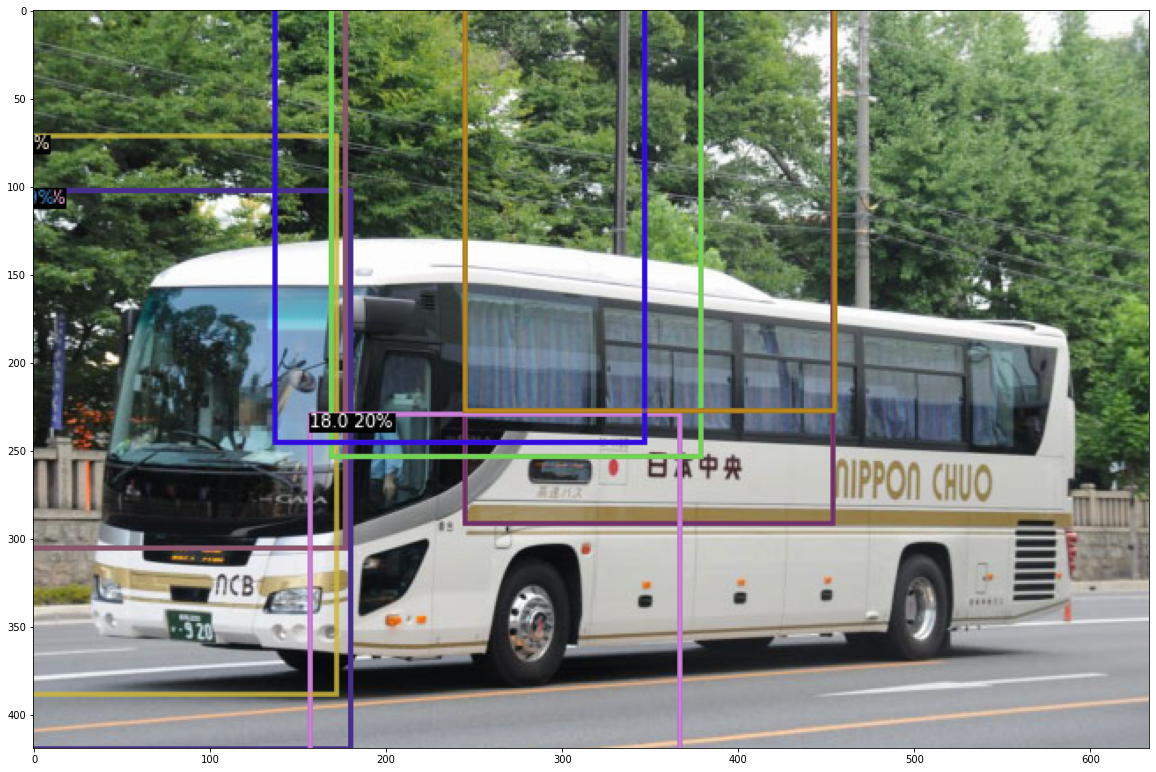

In [39]:
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Instances
from detectron2.data import MetadataCatalog

predict = predicts[0]
scores = predict['scores'].cpu().numpy() * 100
bboxes = predict['boxes'].cpu().numpy()
labels = predict['labels'].cpu().numpy() - 1

indices = np.where(scores > 0.01)

instances = Instances(image.size)
instances.set('scores', scores[indices])
instances.set('pred_boxes', bboxes[indices])
instances.set('pred_classes', labels[indices])

print(instances)

metadata = MetadataCatalog.get('coco_2017_train')
metadata = None
viz = Visualizer(image, metadata)

viz.draw_instance_predictions(instances)
im = viz.get_output().get_image()

plt.rcParams['figure.figsize'] = [20, 16]
plt.imshow(im)